In [11]:
#c1 2 weeks
#c1b
"""
CORRECT and GRID ENVISAT data

 - correct along-tracks SSH with OL monthly climatology offset
 - subtract geoid (egm08, eigen), apply  3m range
 - grid corrected data; bins must have > 30 points
 - land mask is applied

file: dot_env_bmean.nc, dot_env_bmedian.nc

Last modified: 4 Jan 2022
"""

import numpy as np
from numpy import ma

from datetime import datetime
today = datetime.today()

from scipy.stats import binned_statistic_2d as bin2d

import os
import sys
import pickle

import pandas as pd
import xarray as xr
from datetime import timedelta

#-------------------------------------------------------------------------------
# Define directories
voldir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
ncdir = voldir + 'altimetry_cpom/1_raw_nc/'
bindir = voldir + 'altimetry_cpom/2_grid_offset/'
griddir = voldir + 'altimetry_cpom/3_grid_dot/'
lmdir = voldir + 'land_masks/'

scriptdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_scripts/'
auxscriptdir = scriptdir + 'aux_func/'

# import my functions
sys.path.append(auxscriptdir)
from aux_1_filenames import env_id_list as filenames

# Slice filenames for desired subset
start_index = 100
end_index = 117  # exclusive in Python, so this gets index 100 to 116
filenames = filenames[start_index:end_index]
itt = len(filenames)


print(filenames)
#import aux_func_trend as ft
import aux_func as ft

# # # # # # # # # # # #
n_thresh = 30
statistic = 'median'
geoidtype = '_goco05c' #'_egm2008' #'_goco05c' #'_eigen6s4v2_neg'

if geoidtype == '_goco05c':
    geoiddir = voldir + 'geoid/geoid_goco05c/'
elif geoidtype == '_egm2008':
    geoiddir = voldir + 'geoid/geoid_egm2008/'
elif geoidtype == '_eigen6s4v2_neg':
    geoiddir = voldir + 'geoid/geoid_eigen6s4v2_neg/'
# # # # # # # # # # # #

print("- - - - - - - - - - - - - - ")
print("> > bin statistic: %s" % statistic)
print("> > bin threshold: %s points" % str(n_thresh))
print("> > geoid: %s" % geoidtype)
print("- - - - - - - - - - - - - - \n")
#------------------------------------------------------------------
#time = pd.date_range('2002-07-01', '2012-03-01', freq='1MS')
#2 weeks time
#time_start = pd.date_range('2002-07-01', '2012-03-01', freq='1MS')
time_start = pd.date_range('2010-11-01', '2012-03-01', freq='1MS')
time_mid = time_start + timedelta(days=14)
time = time_start.append(time_mid).sort_values()

itt = len(filenames)
assert len(filenames) == itt, f"Expected {itt} filenames, but got {len(filenames)}"

# Check all files have been created
notfound = 0
for i in range(itt):
    filename = ncdir + filenames[i] + '.nc'
    print(filename)
    if (not os.path.isfile(filename)) or (not os.path.exists(filename)):
        notfound += 1

print("%s files in total, %s not found \n" % (itt, notfound))

#------------------------------------------------------------------
# SEASONAL OFFSET
#------------------------------------------------------------------
offsetfile = 'b02_OL_offset_env_' + str(n_thresh) + statistic +'.nc'
with xr.open_dataset(bindir + offsetfile) as offset:
    print(offset.keys())
ol_dif = offset.ol_dif.values
#------------------------------------------------------------------

# LAND MASK
#-------------------------------------------------------------------------------
# lon grid is -180/180, 0.5 lat x 1 lon
# lm shape=(mid_lon, mid_lat)
# land=1, ocean=0
#-------------------------------------------------------------------------------
lm = xr.open_dataset(lmdir+'land_mask_gridded_50S.nc')
lmask = lm.landmask.values

#------------------------------------------------------------------
# BIN DATA
#------------------------------------------------------------------
# bin edges
edges_lon = np.linspace(-180, 180, num=361, endpoint=True)
edges_lat = np.linspace(-82, -50, num=65, endpoint=True)
eglat, eglon = np.meshgrid(edges_lat, edges_lon)

# bin centres
mid_lon = 0.5*(edges_lon[1:] + edges_lon[:-1])
mid_lat = 0.5*(edges_lat[1:] + edges_lat[:-1])
glat, glon = np.meshgrid(mid_lat, mid_lon)

#------------------------------------------------------------------
#------------------------------------------------------------------
## initialize array for the time mean SSH
lo, la = glon.shape
all_DOT = ma.zeros((lo, la, itt))
pts_in_bins = ma.zeros((lo, la, itt))
#-------------------------------------------------------------------------------
for i in range(itt):
    fname = filenames[i]
    print('Analysing M/Y: %s' % fname)

    filepath = ncdir + fname + '.nc'
    data = xr.open_dataset(filepath)

    ssh = data.Elevation.values
    surf = data.SurfaceType.values
    lat = data.Latitude.values
    lon = data.Longitude.values
    dist = data.distance_m.values

    #------------------------------------------------------------------
    # 2 bring leads to the same level as the open ocean data
    #------------------------------------------------------------------
    month = time.month.values[i]
    #print("month %s" % month)

    ssh[surf==2] += ol_dif[month-1]

    # DOT
    print("geoid corrections ..")
    #------------------------------------------------------------------
    # subtract geoid; load only column with geoid height data
    gd_file = geoiddir + fname + geoidtype +'.txt'
    geoid_height = np.loadtxt(gd_file, usecols=2)
    #geoid_height = ma.masked_invalid(geoid_height)

    dot = ssh-geoid_height

    # corr 1 : |DOT| < 3 m
    dot_range = np.logical_and(dot<3, dot>-3)

    dot = dot[dot_range]
    lon = lon[dot_range]
    lat = lat[dot_range]
    dist = dist[dot_range]
    #------------------------------------------------------------------
    # 1 keep only data further than 10km from nearest coastline
    #------------------------------------------------------------------
    dot = dot[dist>1e4]
    lon = lon[dist>1e4]
    lat = lat[dist>1e4]

    #------------------------------------------------------------------
    # 3. BIN DATA
    #------------------------------------------------------------------
    print("binning DOT data ..")
    dot_bin = bin2d(lon, lat, dot, statistic=statistic,
                 bins=[edges_lon, edges_lat]).statistic
    # number of points in bins
    npts = np.histogram2d(lon, lat, bins=(edges_lon, edges_lat))[0]

    # mask bins that have less than a threshold number of points
    dot_bin[npts<n_thresh] = np.nan

    #------------------------------------------------------------------
    # 4. gridded land mask
    #------------------------------------------------------------------
    dot_bin[lmask==1] = np.nan
    npts[lmask==1] = 0

    pts_in_bins[:, :, i] = npts
    #--------------------------------------------------------------------------
    # INTERPOLATION
    #--------------------------------------------------------------------------
    # remove missing data by nearest-neighbour interpolation
    # to prepare data for filtering
    interp_dot = ft.interp_nan(dot_bin, glon, glat)

    # Gaussian filtering
    filt_idot = ft.gaussian_filt(interp_dot, sigma=3, mode='reflect')

    # land mask
    filt_idot[lmask==1] = np.nan

    all_DOT[:, :, i] = ma.masked_invalid(filt_idot)

mean_DOT = ma.mean(all_DOT, axis=-1)
all_SLA = all_DOT - mean_DOT[:, :, np.newaxis]
#-------------------------------------------------------------------------
#2 weekly nc file
from scipy.interpolate import interp1d

print("Interpolating to 2-weekly time grid...")
newfile = '2week_dot_env_30b' + statistic + geoidtype + '_sig3.nc'

# Define original and new time axes
time_orig = pd.date_range('2010-11-01', '2012-03-01', freq='1MS')[:itt]  # Monthly, 117 steps
time_new = time_orig.append(time_orig + timedelta(days=14)).sort_values()  # 2-weekly, 234 steps

# Interpolation function
def interp_var(var, time_dim=-1):
    shape = list(var.shape)
    shape[time_dim] = len(time_new)
    interp_func = interp1d(
        pd.to_datetime(time_orig).astype(np.int64),
        var,
        axis=time_dim,
        bounds_error=False,
        kind='linear',
        fill_value='extrapolate'
    )
    out = interp_func(pd.to_datetime(time_new).astype(np.int64))
    return ma.masked_invalid(out)

# Apply interpolation
all_DOT_interp = interp_var(all_DOT)
all_SLA_interp = interp_var(all_SLA)
pts_in_bins_interp = interp_var(pts_in_bins)

ds = xr.Dataset({
    'dot': (('longitude', 'latitude', 'time'), all_DOT_interp.filled(np.nan)),
    'sla': (('longitude', 'latitude', 'time'), all_SLA_interp.filled(np.nan)),
    'mdt': (('longitude','latitude'), mean_DOT.filled(np.nan)),
    'num_pts': (('longitude', 'latitude', 'time'), pts_in_bins_interp),
    'land_mask': (('longitude', 'latitude'), lmask)},
    coords={
        'longitude': mid_lon,
        'latitude': mid_lat,
        'time': time_new,
        'edge_lat': edges_lat,
        'edge_lon': edges_lon
    })



# #--------------------------------------------------------------------------
# # .nc file
# newfile = 'dot_env_30b' + statistic + geoidtype + '_sig3.nc'
# print("Saving file %s" % newfile)
# #--------------------------------------------------------------------------
# ds = xr.Dataset({'dot' : (('longitude', 'latitude', 'time'), all_DOT.filled(np.nan)),
#                  'sla' : (('longitude', 'latitude', 'time'), all_SLA.filled(np.nan)),
#                  'mdt' : (('longitude','latitude'), mean_DOT.filled(np.nan)),
#                  'num_pts' : (('longitude', 'latitude', 'time'), pts_in_bins),
#                  'land_mask' : (('longitude', 'latitude'), lmask)},
#                 coords={'longitude' : mid_lon,
#                         'latitude' : mid_lat,
#                         'time' : time,
#                         'edge_lat' : edges_lat,
#                         'edge_lon' : edges_lon})

ds.attrs['history'] = "Created " + today.strftime("%d/%m/%Y, %H:%M%S" )

ds.dot.attrs['units']='meters'
ds.sla.attrs['units']='metres'
ds.mdt.attrs['units']='metres'
ds.dot.attrs['long_name']='dynamic_ocean_topography_GOCO05c'
ds.sla.attrs['long_name']='sea_level_anomaly'
ds.mdt.attrs['long_name']='mean_dynamic_ocean_topography'
ds.land_mask.attrs['long_name']='ocean_0_land_1'

ds.attrs['description'] = ("ENVISAT: \
|*Lat, Lon at bin centre and edges \
|*DOT (bin median, only values in (-3, 3)m)\
|*SLA (ref to mean over all period)\
|*MDT\
|*time (2010-11-01, 2012-03-01)\
|*number of points in bins\
|only bins with > 30 points are used\
|*land mask (land=1, ocean=0).\
|Gaussian filter (sig=3, 150km) applied to binned data\
|Data have been filtered by sea-ice type\
and have the land mask applied.")

ds.to_netcdf(griddir + newfile)

['month1011', 'month1012', 'month1101', 'month1102', 'month1103', 'month1104', 'month1105', 'month1106', 'month1107', 'month1108', 'month1109', 'month1110', 'month1111', 'month1112', 'month1201', 'month1202', 'month1203']
- - - - - - - - - - - - - - 
> > bin statistic: median
> > bin threshold: 30 points
> > geoid: _goco05c
- - - - - - - - - - - - - - 

/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/altimetry_cpom/1_raw_nc/month1011.nc
/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/altimetry_cpom/1_raw_nc/month1012.nc
/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/altimetry_cpom/1_raw_nc/month1101.nc
/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/altimetry_cpom/1_raw_nc/month1102.nc
/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/altimetry_cpom/1_raw_nc/month1103.nc
/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/altimetry_cpom/1_raw_nc/month1104.nc
/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/altimetry_cpom/1_raw_nc

In [12]:
print(griddir + newfile)
# env_file = griddir + '2week_dot_env_30b' + statistics + geoidtype + '_sig3.nc'

/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/altimetry_cpom/3_grid_dot/2week_dot_env_30bmedian_goco05c_sig3.nc


In [23]:
#C2
"""
CORRECT and GRID data

 - correct along-tracks SSH with OL & retrackers monthly climatology offset
 - subtract geoid (egm08, goco05c), apply  3m range
 - grid corrected data; bins must have > 30 points
 - land mask is applied

file: dot_cs2_bmean.nc, dot_cs2_bmedian.nc

Last modified: 4 Jan 2022
"""
print('... reading libraries ...')

## libraries go here
import numpy as np
from numpy import ma

from datetime import datetime
today = datetime.today()

from scipy.stats import binned_statistic_2d as bin2d

import os
import sys
import pickle

import pandas as pd
import xarray as xr

#-------------------------------------------------------------------------------
# Define directories
voldir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
ncdir = voldir + 'altimetry_cpom/1_raw_nc/'
bindir = voldir + 'altimetry_cpom/2_grid_offset/'
griddir = voldir + 'altimetry_cpom/3_grid_dot/'
#geoiddir = voldir + 'geoid/geoid_eigen6s4v2/'
#geoiddir = voldir + 'geoid/'
lmdir = voldir + 'land_masks/'

scriptdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_scripts/'
auxscriptdir = scriptdir + 'aux_func/'

sys.path.append(auxscriptdir)
from aux_1_filenames import cs2_id_list as filenames

# Slice filenames for desired subset
start_index = 0
end_index = 17  # exclusive in Python, so this gets index 100 to 116
filenames = filenames[start_index:end_index]
itt = len(filenames)

import aux_func as ft

# # # # # # # # # # # #
# - - - - - - - - - - - - - - - - - - - - - - - -
# n_thresh = 30
# statistic = 'mean'

# # # # # # # # # # # #
n_thresh = 30
statistic = 'median'
geoidtype = '_goco05c' #'_egm2008' #'_goco05c' #'_eigen6s4v2_neg'

if geoidtype == '_goco05c':
    geoiddir = voldir + 'geoid/geoid_goco05c/'
elif geoidtype == '_egm2008':
    geoiddir = voldir + 'geoid/geoid_egm2008/'
elif geoidtype == '_eigen6s4v2_neg':
    geoiddir = voldir + 'geoid/geoid_eigen6s4v2_neg/'
# # # # # # # # # # # #

sig = 3
# - - - - - - - - - - - - - - - - - - - - - - - -
# # # # # # # # # # # #
print("- - - - - - - - - - - - - - ")
print("> > bin statistic: %s" % statistic)
print("> > bin threshold: %s" % str(n_thresh))
print("> > geoid: %s" % geoidtype)
print("> > filter sigma: %s" % sig)
print("- - - - - - - - - - - - - - \n")
#------------------------------------------------------------------
# start from 2010-11-01
# time = pd.date_range('2010-11-01', '2012-03-01', freq='1MS')
#time 2 weekly
time_start = pd.date_range('2010-11-01', '2012-03-01', freq='1MS')
time_mid = time_start + timedelta(days=14)
time = time_start.append(time_mid).sort_values()

itt = len(filenames)

# Check all files have been created
notfound = 0
for i in range(itt):
    filename = ncdir + filenames[i] + '.nc'
    if (not os.path.isfile(filename)) or (not os.path.exists(filename)):
        notfound += 1

print("%s files in total, %s not found \n" % (itt, notfound))
print("first file %s" %filenames[0])
print('start time', time[0])
#------------------------------------------------------------------
# SEASONAL OFFSET
#------------------------------------------------------------------
offsetfile = 'b02_OL_offset_cs2_'+ str(n_thresh) + statistic + '.nc'
with xr.open_dataset(bindir + offsetfile) as ol:
    print(ol.keys())
ol_dif = ol.ol_dif.values

offsetfile2 = 'b03_SAR_offset_cs2_' + str(n_thresh) + statistic +'.nc'
with xr.open_dataset(bindir + offsetfile2) as retracker1:
    print(retracker1.keys())
sarin_dif = retracker1.sar_dif.values

offsetfile3 = 'b04_LRM_offset_cs2_' + str(n_thresh) + statistic + '.nc'
with xr.open_dataset(bindir + offsetfile3) as retracker2:
    print(retracker2.keys())
sar_dif = retracker2.lrm_dif.values
#------------------------------------------------------------------

# LAND MASK
#-------------------------------------------------------------------------------
# lon grid is -180/180, 0.5 lat x 1 lon
# lm shape=(mid_lon, mid_lat)
# land=1, ocean=0
#-------------------------------------------------------------------------------
lm = xr.open_dataset(lmdir+'land_mask_gridded_50S.nc')
lmask = lm.landmask.values

#------------------------------------------------------------------
# BIN DATA
#------------------------------------------------------------------
# bin edges
edges_lon = np.linspace(-180, 180, num=361, endpoint=True)
edges_lat = np.linspace(-82, -50, num=65, endpoint=True)
eglat, eglon = np.meshgrid(edges_lat, edges_lon)

# bin centres
mid_lon = 0.5*(edges_lon[1:] + edges_lon[:-1])
mid_lat = 0.5*(edges_lat[1:] + edges_lat[:-1])
glat, glon = np.meshgrid(mid_lat, mid_lon)

#------------------------------------------------------------------
#------------------------------------------------------------------
## initialize array for the time mean SSH
lo, la = glon.shape
all_DOT = ma.zeros((lo, la, itt))
pts_in_bins = ma.zeros((lo, la, itt))
#-------------------------------------------------------------------------------
for i in range(itt):
    fname = filenames[i]
    print(f'Analysing M/Y: {fname}')

    filepath = ncdir + fname + '.nc'

    try:
        data = xr.open_dataset(filepath)

        # Check that required variables are present and dataset is not empty
        required_vars = ['Latitude', 'Longitude', 'Elevation', 'SurfaceType', 'distance_m', 'MeanSSH', 'Time']
        if not all(var in data.variables for var in required_vars) or data.sizes == {}:
            print(f"MERGE {fname} is empty or missing required variables")
            continue

    except FileNotFoundError:
        print(f"MERGE {fname} not available")
        continue

    ssh = data.Elevation.values
    surf = data.SurfaceType.values
    lat = data.Latitude.values
    lon = data.Longitude.values
    dist = data.distance_m.values
    retracker = data.Retracker.values

    #------------------------------------------------------------------
    # 2 bring leads to the same level as the open ocean data
    #------------------------------------------------------------------
    month = time.month.values[i]
    ssh[surf==2] += ol_dif[month-1]

    # LRM, SAR, SARIN correction - ref to LRM
    #------------------------------------------------------------------
    ssh[retracker==2] += sar_dif[month-1]
    ssh[retracker==3] += (sarin_dif[month-1] + sar_dif[month-1])

    # DOT
    print("geoid corrections ..")
    #------------------------------------------------------------------
    # subtract geoid; load only column with geoid height data
    gd_file = geoiddir + fname + geoidtype +'.txt'
    # geoid_height = np.loadtxt(gd_file, usecols=2)
    # #geoid_height = ma.masked_invalid(geoid_height)

    try:
        geoid_height = np.loadtxt(gd_file, usecols=2)
    except Exception as e:
        print(f"Failed to read geoid for {fname}: {e}")
        continue

    if ssh.shape[0] != geoid_height.shape[0]:
        print(f"Skipping {fname} due to mismatch in SSH ({ssh.shape[0]}) and geoid ({geoid_height.shape[0]}) lengths.")
        continue

    dot = ssh-geoid_height

    # corr 1 : |DOT| < 3 m
    dot_range = np.logical_and(dot<3, dot>-3)

    dot = dot[dot_range]
    lon = lon[dot_range]
    lat = lat[dot_range]
    dist = dist[dot_range]
    #------------------------------------------------------------------
    # 1 keep only data further than 10km from nearest coastline
    #------------------------------------------------------------------
    dot = dot[dist>1e4]
    lon = lon[dist>1e4]
    lat = lat[dist>1e4]

    #------------------------------------------------------------------
    # 3. BIN DATA
    #------------------------------------------------------------------
    print("binning DOT data ..")
    dot_bin = bin2d(lon, lat, dot, statistic=statistic,
            bins=[edges_lon, edges_lat]).statistic
    # number of points in bins
    npts = np.histogram2d(lon, lat, bins=(edges_lon, edges_lat))[0]

    # mask bins that have less than a threshold number of points
    dot_bin[npts<n_thresh] = np.nan

    #------------------------------------------------------------------
    # 4. gridded land mask
    #------------------------------------------------------------------
    dot_bin[lmask==1] = np.nan
    npts[lmask==1] = 0

    pts_in_bins[:, :, i] = npts

  #--------------------------------------------------------------------------
    # INTERPOLATION
    #--------------------------------------------------------------------------
    # remove missing data by nearest-neighbour interpolation
    # to prepare data for filtering
    interp_dot = ft.interp_nan(dot_bin, glon, glat)

    # Gaussian filtering
    filt_idot = ft.gaussian_filt(interp_dot, sigma=3, mode='reflect')

    # land mask
    filt_idot[lmask==1] = np.nan

    all_DOT[:, :, i] = ma.masked_invalid(filt_idot)

mean_DOT = ma.mean(all_DOT, axis=-1)
all_SLA = all_DOT - mean_DOT[:, :, np.newaxis]
#-------------------------------------------------------------------------
#2 weekly nc file
from scipy.interpolate import interp1d

print("Interpolating to 2-weekly time grid...")
newfile = '2week_dot_cs2_30b' + statistic + geoidtype + '_sig3.nc'

# Define original and new time axes
time_orig = pd.date_range('2010-11-01', '2012-03-01', freq='1MS')[:itt]  # Monthly, 117 steps
time_new = time_orig.append(time_orig + timedelta(days=14)).sort_values()  # 2-weekly, 234 steps

# Interpolation function
def interp_var(var, time_dim=-1):
    shape = list(var.shape)
    shape[time_dim] = len(time_new)
    interp_func = interp1d(
        pd.to_datetime(time_orig).astype(np.int64),
        var,
        axis=time_dim,
        bounds_error=False,
        kind='linear',
        fill_value='extrapolate'
    )
    out = interp_func(pd.to_datetime(time_new).astype(np.int64))
    return ma.masked_invalid(out)

# Apply interpolation
all_DOT_interp = interp_var(all_DOT)
all_SLA_interp = interp_var(all_SLA)
pts_in_bins_interp = interp_var(pts_in_bins)

ds = xr.Dataset({
    'dot': (('longitude', 'latitude', 'time'), all_DOT_interp.filled(np.nan)),
    'sla': (('longitude', 'latitude', 'time'), all_SLA_interp.filled(np.nan)),
    'mdt': (('longitude','latitude'), mean_DOT.filled(np.nan)),
    'num_pts': (('longitude', 'latitude', 'time'), pts_in_bins_interp),
    'land_mask': (('longitude', 'latitude'), lmask)},
    coords={
        'longitude': mid_lon,
        'latitude': mid_lat,
        'time': time_new,
        'edge_lat': edges_lat,
        'edge_lon': edges_lon
    })



# #--------------------------------------------------------------------------
# # .nc file
# newfile = 'dot_env_30b' + statistic + geoidtype + '_sig3.nc'
# print("Saving file %s" % newfile)
# #--------------------------------------------------------------------------
# ds = xr.Dataset({'dot' : (('longitude', 'latitude', 'time'), all_DOT.filled(np.nan)),
#                  'sla' : (('longitude', 'latitude', 'time'), all_SLA.filled(np.nan)),
#                  'mdt' : (('longitude','latitude'), mean_DOT.filled(np.nan)),
#                  'num_pts' : (('longitude', 'latitude', 'time'), pts_in_bins),
#                  'land_mask' : (('longitude', 'latitude'), lmask)},
#                 coords={'longitude' : mid_lon,
#                         'latitude' : mid_lat,
#                         'time' : time,
#                         'edge_lat' : edges_lat,
#                         'edge_lon' : edges_lon})

ds.attrs['history'] = "Created " + today.strftime("%d/%m/%Y, %H:%M%S" )

ds.dot.attrs['units']='meters'
ds.sla.attrs['units']='metres'
ds.mdt.attrs['units']='metres'
ds.dot.attrs['long_name']='dynamic_ocean_topography_GOCO05c'
ds.sla.attrs['long_name']='sea_level_anomaly'
ds.mdt.attrs['long_name']='mean_dynamic_ocean_topography'
ds.land_mask.attrs['long_name']='ocean_0_land_1'

ds.attrs['description'] = ("CS2: \
|*Lat, Lon at bin centre and edges \
|*DOT (bin median, only values in (-3, 3)m)\
|*SLA (ref to mean over all period)\
|*MDT\
|*time (2010-11-01, 2012-03-01)\
|*number of points in bins\
|only bins with > 30 points are used\
|*land mask (land=1, ocean=0).\
|Gaussian filter (sig=3, 150km) applied to binned data\
|Data have been filtered by sea-ice type\
and have the land mask applied.")

ds.to_netcdf(griddir + newfile)
print("Done.")


... reading libraries ...
- - - - - - - - - - - - - - 
> > bin statistic: median
> > bin threshold: 30
> > geoid: _goco05c
> > filter sigma: 3
- - - - - - - - - - - - - - 

17 files in total, 0 not found 

first file 201011_MERGE
start time 2010-11-01 00:00:00
KeysView(<xarray.Dataset> Size: 288B
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    ol_dif   (month) float64 96B ...
    ol_std   (month) float64 96B ...)
KeysView(<xarray.Dataset> Size: 288B
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sar_dif  (month) float64 96B ...
    sar_std  (month) float64 96B ...)
KeysView(<xarray.Dataset> Size: 288B
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    lrm_dif  (month) float64 96B ...
    lrm_std  (month) float64 96B ...)
Analysing M/Y: 201011_MERGE
geoid corrections ..
binning DOT data .

KeysView(<xarray.Dataset> Size: 19MB
Dimensions:    (longitude: 360, latitude: 64, time: 34, edge_lat: 65,
                edge_lon: 361)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * time       (time) datetime64[ns] 272B 2010-11-01 2010-11-15 ... 2012-03-15
  * edge_lat   (edge_lat) float64 520B -82.0 -81.5 -81.0 ... -51.0 -50.5 -50.0
  * edge_lon   (edge_lon) float64 3kB -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
Data variables:
    dot        (longitude, latitude, time) float64 6MB ...
    sla        (longitude, latitude, time) float64 6MB ...
    mdt        (longitude, latitude) float64 184kB ...
    num_pts    (longitude, latitude, time) float64 6MB ...
    land_mask  (longitude, latitude) float64 184kB ...
Attributes:
    history:      Created 30/05/2025, 16:5807
    description:  CS2: |*Lat, Lon at bin centre and edges |*DOT (bin median, ...)
KeysView(<xar

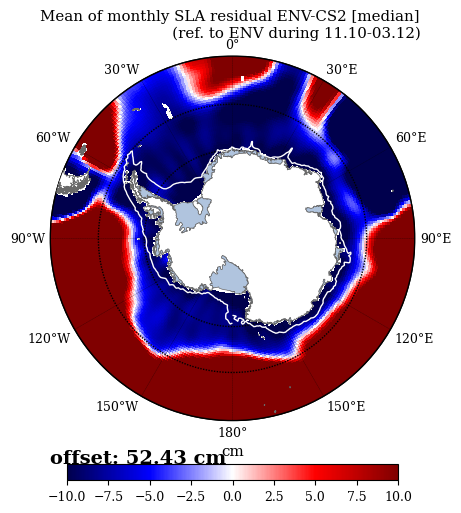

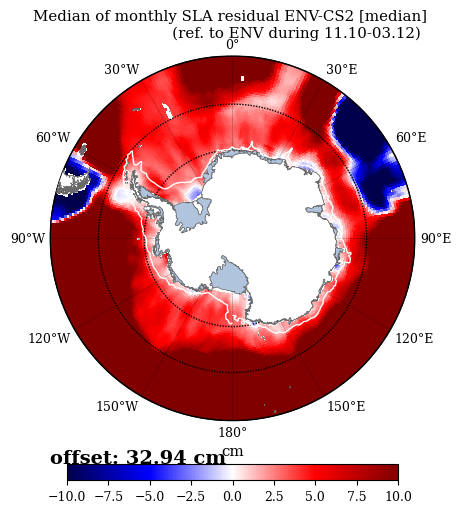

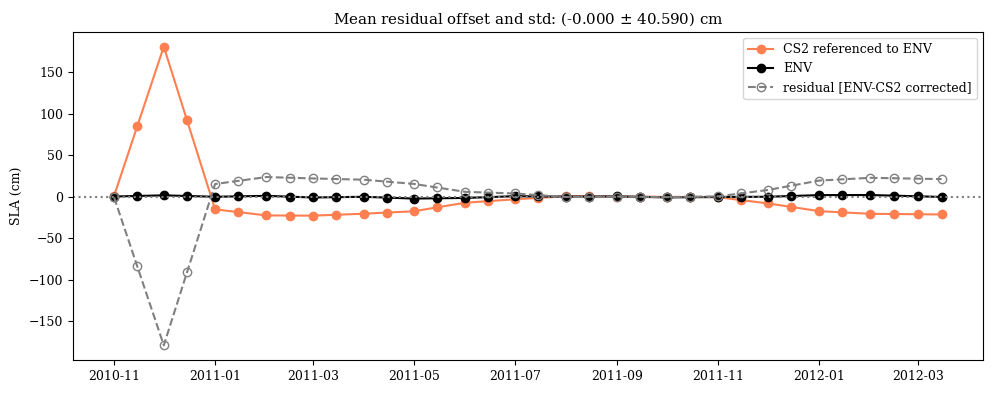

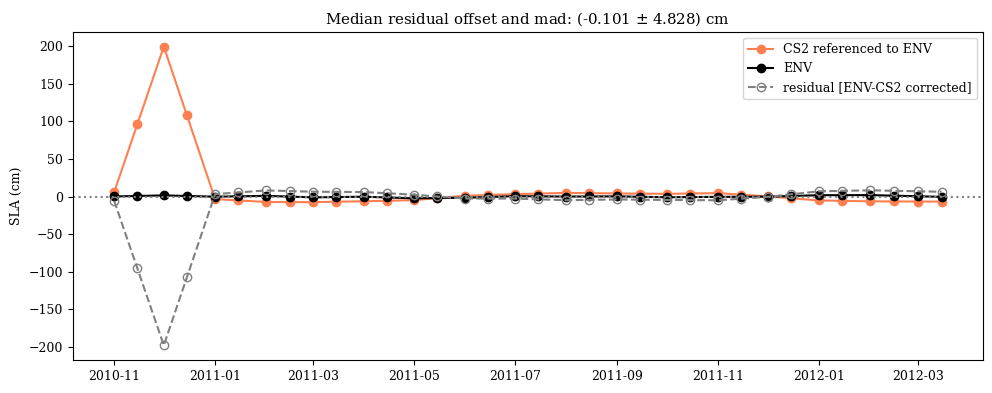

In [9]:
#ch3
"""
Compute SLA referenced to the ENV_MDT overlap period.


Last modified: 31 Mar 2021
"""

import numpy as np
from numpy import ma

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib

from palettable.colorbrewer.diverging import RdBu_11, PuOr_11

import xarray as xr
import pandas as pd

import sys

#----------------------------------------------------------
# Define directories
voldir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
griddir = voldir + 'altimetry_cpom/3_grid_dot/'
lmdir = voldir + 'land_masks/'
figdir = voldir + '../PhD_figures/Figures_v8/'

scriptdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_scripts/'
auxscriptdir = scriptdir + '/aux_func/'

sys.path.append(auxscriptdir)
from aux_1_filenames import cs2_id_list as filenames
import aux_func as ft


sys.path.append(auxscriptdir)
import aux_func as fc
import aux_stereoplot as st

#----------------------------------------------------------

# Intersatellite offset (median, metres)
#intersat_off = 0.041465 # for SLA (SSH-geoid); filt sigma=2 grid cells
#intersat_off = 0.041638 # filter sigma=1 grid cell
#intersat_off = 0.041194 # for SSHA (SSH-MSS)
# 7, sigma=2
#intersat_off = 0.037405
#7, sigma=3
#intersat_off = 0.037129

# 3 may 2020:
#intersat_off = 0.03712

#----------------------------------------------------------

# # # # # # # # # # # #
geoidtype = '_goco05c'#'_eigen6s4v2_neg' #'_egm2008' #'_goco05c'
statistics = 'median'
# # # # # # # # # # # #

cs2_file = griddir + '2week_dot_cs2_30b' + statistics + geoidtype + '_sig3.nc'
env_file = griddir + '2week_dot_env_30b' + statistics + geoidtype + '_sig3.nc'

with xr.open_dataset(cs2_file) as cs2_dict:
    print(cs2_dict.keys())
with xr.open_dataset(env_file) as env_dict:
    print(env_dict.keys())

# overlap period
time = pd.date_range('2010-11-01', '2012-03-01', freq='1MS')

# overlap period - 2 weeks avg
time_start = pd.date_range('2010-11-01', '2012-03-01', freq='1MS')
time_mid = time_start + timedelta(days=14)
time = time_start.append(time_mid).sort_values()


env = env_dict.sel(time=slice(time[0], time[-1]))
cs2 = cs2_dict.sel(time=slice(time[0], time[-1]))

print(env.keys())
print(cs2.keys())

# LAT/LON GRID
lat = env.latitude.values
lon = env.longitude.values
elat = env.edge_lat.values
elon = env.edge_lon.values

eglat, eglon = np.meshgrid(elat, elon)

lmask = env.land_mask.values

#----------------------------------------------------------
# OVERLAP PERIOD SLA OFFSET
#----------------------------------------------------------
itt = len(time)

cs2_mdt = cs2.dot.mean('time')
env_mdt = env.dot.mean('time')

cs2_sla = cs2.dot - env_mdt
env_sla = env.dot - env_mdt

# # # # # # # # # # # #
# SLA residual - time series of maps
sla_dif = env_sla - cs2_sla

# map of mean/median residual
sla_dif_median = sla_dif.median("time").values
sla_dif_mean = sla_dif.mean("time").values

#----------------------------------------------------------
# area-weighted circumpolar SLA average - time series
#----------------------------------------------------------
area_grid = fc.grid_area(eglon, eglat)
area_grid[lmask==1] = np.nan # mask where land

# mask cells where the offset is negative
res_median = sla_dif_median.copy()
res_mean = sla_dif_mean.copy()

res_median[res_median<0] = np.nan
res_mean[res_mean<0] = np.nan

# area weighted average
a1 = res_mean*area_grid
a2 = res_median*area_grid

area1_sum = np.nansum(area_grid[~np.isnan(a1)])
area2_sum = np.nansum(area_grid[~np.isnan(a2)])

avg_off1 = np.nansum(a1)/area1_sum
avg_off2 = np.nansum(a2)/area2_sum

print("mean area weighted avg: %s (m)" % avg_off1)
print("median area weighted avg: %s (m)" % avg_off2)

#----------------------------------------------------------
#           PLOT of mean/median of RESIDUAL
#----------------------------------------------------------
cbar_range = [-10, 10]
cbar_units = 'cm'
cmap = cm.seismic

# # # # # # # # # # # #
fig, ax, m = st.spstere_plot(eglon, eglat, sla_dif_mean*1e2,
                cbar_range, cmap, cbar_units, 'w')
fig.tight_layout(rect=[0, -.1, 1, .95])
fig.suptitle(('{}').format('Mean of monthly SLA residual ENV-CS2 [%s] \n\
                           (ref. to ENV during 11.10-03.12)' % statistics))
ax.annotate('offset: %.2f cm' % (avg_off1*1e2),
    xy=(.1,.1),
    xycoords='figure fraction',
    weight='bold', fontsize=14)


# # # # # # # # # # # #

fig, ax, m = st.spstere_plot(eglon, eglat, sla_dif_median*1e2,
                cbar_range, cmap, cbar_units, 'w')
fig.tight_layout(rect=[0, -.1, 1, .95])
fig.suptitle(('{}').format('Median of monthly SLA residual ENV-CS2 [%s] \n\
                           (ref. to ENV during 11.10-03.12)' % statistics))
ax.annotate('offset: %.2f cm' % (avg_off2*1e2),
    xy=(.1,.1),
    xycoords='figure fraction',
    weight='bold', fontsize=14)

#sys.exit()
# stop here


# # # # # # # # # # # #
# # save in a file
# offset = xr.Dataset({'mean_map' : (('longitude', 'latitude'), sla_dif_mean),
#                     'median_map' : (('longitude', 'latitude'), sla_dif_median),
#                     'mean_aw_avg' : avg_off1,
#                     'median_aw_avg' : avg_off2},
#                     coords={'longitude' : lon,
#                     'latitude' : lat})
# offset.to_netcdf(griddir + 'intersat_off_b' + statistics + '.nc')

# A. correct CS2 SLA with the aw avg of the mean in every cell
# - - - - - - - - - - - - - - - - - - - -
cs2_sla_v = cs2_sla.values + avg_off1
env_sla_v = env_sla.values

# and compare area-weighted averaged time series
env_sla_v[sla_dif_mean<0] = np.nan
cs2_sla_v[sla_dif_mean<0] = np.nan

# - - - - - - - - - - - - - - - - - - - -
# area-weighted avg and residual
avg_sla_cs2, avg_sla_env = [ma.ones((itt, )) for _ in range(2)]
for i in range(itt):
    aa = ma.masked_invalid(cs2_sla_v[:, :, i]*area_grid)
    total_area = ma.sum(area_grid[~aa.mask])
    avg_sla_cs2[i] = ma.sum(aa)/total_area

    bb = ma.masked_invalid(env_sla_v[:, :, i]*area_grid)
    total_area = ma.sum(area_grid[~bb.mask])
    avg_sla_env[i] = ma.sum(bb)/total_area

# difference between satellites; mean and median of time series
overlap_median = ma.median(avg_sla_env - avg_sla_cs2)
overlap_mad = ma.median(abs((avg_sla_env-avg_sla_cs2)-overlap_median))

overlap_mean = ma.mean(avg_sla_env - avg_sla_cs2)
overlap_std = ma.std(avg_sla_env-avg_sla_cs2, ddof=1)

print("Envisat - CS2 offset (cm) ")
print("median: %.4f + %.4f cm" %(overlap_median*1e2,
                                 overlap_mad*1e2))
print("  mean: %.4f + %.4f cm" %(overlap_mean*1e2,
                                 overlap_std*1e2))

#----------------------------------------------------------

plt.ion()
fig, ax =  plt.subplots(figsize=(10, 4))
x = time
ax.plot(x, (avg_sla_cs2)*1e2,
        c='coral', marker='o',
        label='CS2 referenced to ENV')
ax.plot(x, avg_sla_env*1e2, c='k',
        marker='o',
        label='ENV')
ax.plot(x, (avg_sla_env-avg_sla_cs2)*1e2,
        c='grey', ls='--',
        marker='o', markerfacecolor='none',
        label='residual [ENV-CS2 corrected]')
ax.axhline(0, ls=':', c='grey')
ax.legend()
ax.set_ylabel("SLA (cm)")
ax.set_title(r"Mean residual offset and std: (%.3f $\pm$ %.3f) cm"
             % (overlap_mean*1e2, overlap_std*1e2))
plt.tight_layout()

#----------------------------------------------------------
#----------------------------------------------------------
# A. correct CS2 SLA with the aw avg of the median in every cell
# - - - - - - - - - - - - - - - - - - - -
cs2_sla_v = cs2_sla.values + avg_off2
env_sla_v = env_sla.values

# and compare area-weighted averaged time series
env_sla_v[sla_dif_median<0] = np.nan
cs2_sla_v[sla_dif_median<0] = np.nan

# - - - - - - - - - - - - - - - - - - - -
# area-weighted avg and residual
avg_sla_cs2, avg_sla_env = [ma.ones((itt, )) for _ in range(2)]
for i in range(itt):
    aa = ma.masked_invalid(cs2_sla_v[:, :, i]*area_grid)
    total_area = ma.sum(area_grid[~aa.mask])
    avg_sla_cs2[i] = ma.sum(aa)/total_area

    bb = ma.masked_invalid(env_sla_v[:, :, i]*area_grid)
    total_area = ma.sum(area_grid[~bb.mask])
    avg_sla_env[i] = ma.sum(bb)/total_area

# difference between satellites; mean and median of time series
overlap_median = ma.median(avg_sla_env - avg_sla_cs2)
overlap_mad = ma.median(abs((avg_sla_env-avg_sla_cs2)-overlap_median))

overlap_mean = ma.mean(avg_sla_env - avg_sla_cs2)
overlap_std = ma.std(avg_sla_env-avg_sla_cs2, ddof=1)

print("Envisat - CS2 offset (cm) ")
print("median: %.4f + %.4f cm" %(overlap_median*1e2,
                                 overlap_mad*1e2))
print("  mean: %.4f + %.4f cm" %(overlap_mean*1e2,
                                 overlap_std*1e2))

#----------------------------------------------------------

plt.ion()
fig, ax =  plt.subplots(figsize=(10, 4))
x = time
ax.plot(x, (avg_sla_cs2)*1e2,
        c='coral', marker='o',
        label='CS2 referenced to ENV')
ax.plot(x, avg_sla_env*1e2, c='k',
        marker='o',
        label='ENV')
ax.plot(x, (avg_sla_env-avg_sla_cs2)*1e2,
        c='grey', ls='--',
        marker='o', markerfacecolor='none',
        label='residual [ENV-CS2 corrected]')
ax.axhline(0, ls=':', c='grey')
ax.legend()
ax.set_ylabel("SLA (cm)")
ax.set_title(r"Median residual offset and mad: (%.3f $\pm$ %.3f) cm"
             % (overlap_median*1e2, overlap_mad*1e2))
plt.tight_layout()

#----------------------------------------------------------

# save a mask with 1s where the offset > 0 and 0 everywhere else - commented this as msla not a vairbale
# dif_mask = ma.ones((msla_dif.shape))
# dif_mask[msla_dif.mask==True] = ma.masked
# dif_mask[msla_dif<0]=0
# lo, la = dif_mask.shape
# elo, ela = len(elon), len(elat)

sla_dif_ma = ma.masked_invalid(sla_dif.values)
dif_mask = ma.ones((sla_dif.shape))
dif_mask[sla_dif_ma.mask==True] = ma.masked
dif_mask[sla_dif_ma<0]=0

lo, la, time = dif_mask.shape
elo, ela = len(elon), len(elat)

plt.show()







In [8]:
print(dif_mask.shape)

(360, 64, 34)


KeysView(<xarray.Dataset> Size: 19MB
Dimensions:    (longitude: 360, latitude: 64, time: 34, edge_lat: 65,
                edge_lon: 361)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * time       (time) datetime64[ns] 272B 2010-11-01 2010-11-15 ... 2012-03-15
  * edge_lat   (edge_lat) float64 520B -82.0 -81.5 -81.0 ... -51.0 -50.5 -50.0
  * edge_lon   (edge_lon) float64 3kB -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
Data variables:
    dot        (longitude, latitude, time) float64 6MB ...
    sla        (longitude, latitude, time) float64 6MB ...
    mdt        (longitude, latitude) float64 184kB ...
    num_pts    (longitude, latitude, time) float64 6MB ...
    land_mask  (longitude, latitude) float64 184kB ...
Attributes:
    history:      Created 30/05/2025, 16:5807
    description:  CS2: |*Lat, Lon at bin centre and edges |*DOT (bin median, ...)
KeysView(<xar

SystemExit: 

/Users/iw2g24/PycharmProjects/SSH_project/.venv1/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


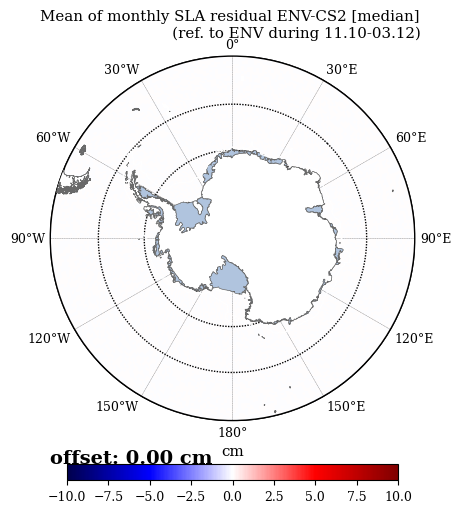

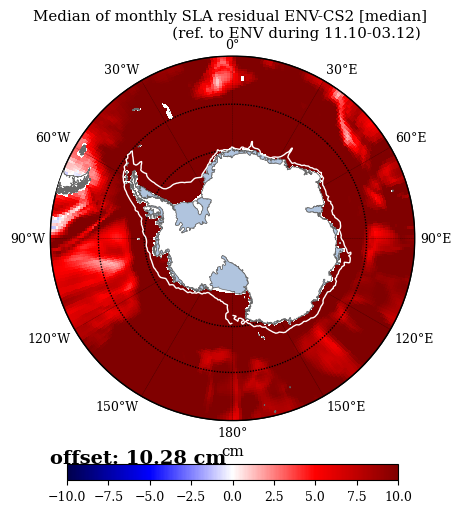

In [10]:
#c3

"""
Compute SLA referenced to the ENV_MDT overlap period.


Last modified: 31 Mar 2021
"""

import numpy as np
from numpy import ma

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib

from palettable.colorbrewer.diverging import RdBu_11, PuOr_11

import xarray as xr
import pandas as pd

import sys

#----------------------------------------------------------
# Define directories
voldir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
griddir = voldir + 'altimetry_cpom/3_grid_dot/'
lmdir = voldir + 'land_masks/'
figdir = voldir + '../PhD_figures/Figures_v8/'

scriptdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_scripts/'
auxscriptdir = scriptdir + '/aux_func/'

sys.path.append(auxscriptdir)
from aux_1_filenames import cs2_id_list as filenames
import aux_func as ft


sys.path.append(auxscriptdir)
import aux_func as fc
import aux_stereoplot as st

#----------------------------------------------------------

# Intersatellite offset (median, metres)
#intersat_off = 0.041465 # for SLA (SSH-geoid); filt sigma=2 grid cells
#intersat_off = 0.041638 # filter sigma=1 grid cell
#intersat_off = 0.041194 # for SSHA (SSH-MSS)
# 7, sigma=2
#intersat_off = 0.037405
#7, sigma=3
#intersat_off = 0.037129

# 3 may 2020:
#intersat_off = 0.03712

#----------------------------------------------------------

# # # # # # # # # # # #
geoidtype = '_goco05c'#'_eigen6s4v2_neg' #'_egm2008' #'_goco05c'
statistics = 'median'
# # # # # # # # # # # #

cs2_file = griddir + '2week_dot_cs2_30b' + statistics + geoidtype + '_sig3.nc'
env_file = griddir + '2week_dot_env_30b' + statistics + geoidtype + '_sig3.nc'

with xr.open_dataset(cs2_file) as cs2_dict:
    print(cs2_dict.keys())
with xr.open_dataset(env_file) as env_dict:
    print(env_dict.keys())

# overlap period
time = pd.date_range('2010-11-01', '2012-03-01', freq='1MS')

# overlap period - 2 weeks avg
time_start = pd.date_range('2010-11-01', '2012-03-01', freq='1MS')
time_mid = time_start + timedelta(days=14)
time = time_start.append(time_mid).sort_values()


env = env_dict.sel(time=slice(time[0], time[-1]))
cs2 = cs2_dict.sel(time=slice(time[0], time[-1]))

print(env.keys())
print(cs2.keys())

# LAT/LON GRID
lat = env.latitude.values
lon = env.longitude.values
elat = env.edge_lat.values
elon = env.edge_lon.values

eglat, eglon = np.meshgrid(elat, elon)

lmask = env.land_mask.values

#----------------------------------------------------------
# OVERLAP PERIOD SLA OFFSET
#----------------------------------------------------------
itt = len(time)

cs2_mdt = cs2.dot.mean('time')
env_mdt = env.dot.mean('time')

cs2_sla = cs2.dot - cs2_mdt
env_sla = env.dot - env_mdt

# # # # # # # # # # # #
# SLA residual - time series of maps
sla_dif = env_sla - cs2_sla

# map of mean/median residual
sla_dif_median = sla_dif.median("time").values
sla_dif_mean = sla_dif.mean("time").values

#----------------------------------------------------------
# area-weighted circumpolar SLA average - time series
#----------------------------------------------------------
area_grid = fc.grid_area(eglon, eglat)
area_grid[lmask==1] = np.nan # mask where land

# mask cells where the offset is negative
res_median = sla_dif_median.copy()
res_mean = sla_dif_mean.copy()

res_median[res_median<0] = np.nan
res_mean[res_mean<0] = np.nan

# area weighted average
a1 = res_mean*area_grid
a2 = res_median*area_grid

area1_sum = np.nansum(area_grid[~np.isnan(a1)])
area2_sum = np.nansum(area_grid[~np.isnan(a2)])

avg_off1 = np.nansum(a1)/area1_sum
avg_off2 = np.nansum(a2)/area2_sum

print("mean area weighted avg: %s (m)" % avg_off1)
print("median area weighted avg: %s (m)" % avg_off2)

#----------------------------------------------------------
#           PLOT of mean/median of RESIDUAL
#----------------------------------------------------------
cbar_range = [-10, 10]
cbar_units = 'cm'
cmap = cm.seismic
both = 'w'
# # # # # # # # # # # #
fig, ax, m = st.spstere_plot(eglon, eglat, sla_dif_mean*1e2,
                cbar_range, cmap, cbar_units, both)
fig.tight_layout(rect=[0, -.1, 1, .95])
fig.suptitle(('{}').format('Mean of monthly SLA residual ENV-CS2 [%s] \n\
                           (ref. to ENV during 11.10-03.12)' % statistics))
ax.annotate('offset: %.2f cm' % (avg_off1*1e2),
    xy=(.1,.1),
    xycoords='figure fraction',
    weight='bold', fontsize=14)


# # # # # # # # # # # #
both = 'w'
fig, ax, m = st.spstere_plot(eglon, eglat, sla_dif_median*1e2,
                cbar_range, cmap, cbar_units, both)
fig.tight_layout(rect=[0, -.1, 1, .95])
fig.suptitle(('{}').format('Median of monthly SLA residual ENV-CS2 [%s] \n\
                           (ref. to ENV during 11.10-03.12)' % statistics))
ax.annotate('offset: %.2f cm' % (avg_off2*1e2),
    xy=(.1,.1),
    xycoords='figure fraction',
    weight='bold', fontsize=14)

sys.exit() # - use if want to stop !!!
# stop here


# # # # # # # # # # # #
# # save in a file
# offset = xr.Dataset({'mean_map' : (('longitude', 'latitude'), sla_dif_mean),
#                     'median_map' : (('longitude', 'latitude'), sla_dif_median),
#                     'mean_aw_avg' : avg_off1,
#                     'median_aw_avg' : avg_off2},
#                     coords={'longitude' : lon,
#                     'latitude' : lat})
# offset.to_netcdf(griddir + 'intersat_off_b' + statistics + '.nc')

# A. correct CS2 SLA with the aw avg of the mean in every cell
# - - - - - - - - - - - - - - - - - - - -
cs2_sla_v = cs2_sla.values + avg_off1
env_sla_v = env_sla.values

# and compare area-weighted averaged time series
env_sla_v[sla_dif_mean<0] = np.nan
cs2_sla_v[sla_dif_mean<0] = np.nan

# - - - - - - - - - - - - - - - - - - - -
# area-weighted avg and residual
avg_sla_cs2, avg_sla_env = [ma.ones((itt, )) for _ in range(2)]
for i in range(itt):
    aa = ma.masked_invalid(cs2_sla_v[:, :, i]*area_grid)
    total_area = ma.sum(area_grid[~aa.mask])
    avg_sla_cs2[i] = ma.sum(aa)/total_area

    bb = ma.masked_invalid(env_sla_v[:, :, i]*area_grid)
    total_area = ma.sum(area_grid[~bb.mask])
    avg_sla_env[i] = ma.sum(bb)/total_area

# difference between satellites; mean and median of time series
overlap_median = ma.median(avg_sla_env - avg_sla_cs2)
overlap_mad = ma.median(abs((avg_sla_env-avg_sla_cs2)-overlap_median))

overlap_mean = ma.mean(avg_sla_env - avg_sla_cs2)
overlap_std = ma.std(avg_sla_env-avg_sla_cs2, ddof=1)

print("Envisat - CS2 offset (cm) ")
print("median: %.4f + %.4f cm" %(overlap_median*1e2,
                                 overlap_mad*1e2))
print("  mean: %.4f + %.4f cm" %(overlap_mean*1e2,
                                 overlap_std*1e2))

#----------------------------------------------------------

plt.ion()
fig, ax =  plt.subplots(figsize=(10, 4))
x = time
ax.plot(x, (avg_sla_cs2)*1e2,
        c='coral', marker='o',
        label='CS2 referenced to ENV')
ax.plot(x, avg_sla_env*1e2, c='k',
        marker='o',
        label='ENV')
ax.plot(x, (avg_sla_env-avg_sla_cs2)*1e2,
        c='grey', ls='--',
        marker='o', markerfacecolor='none',
        label='residual [ENV-CS2 corrected]')
ax.axhline(0, ls=':', c='grey')
ax.legend()
ax.set_ylabel("SLA (cm)")
ax.set_title(r"Mean residual offset and std: (%.3f $\pm$ %.3f) cm"
             % (overlap_mean*1e2, overlap_std*1e2))
plt.tight_layout()

#----------------------------------------------------------
#----------------------------------------------------------
# A. correct CS2 SLA with the aw avg of the median in every cell
# - - - - - - - - - - - - - - - - - - - -
cs2_sla_v = cs2_sla.values + avg_off2
env_sla_v = env_sla.values

# and compare area-weighted averaged time series
env_sla_v[sla_dif_median<0] = np.nan
cs2_sla_v[sla_dif_median<0] = np.nan

# - - - - - - - - - - - - - - - - - - - -
# area-weighted avg and residual
avg_sla_cs2, avg_sla_env = [ma.ones((itt, )) for _ in range(2)]
for i in range(itt):
    aa = ma.masked_invalid(cs2_sla_v[:, :, i]*area_grid)
    total_area = ma.sum(area_grid[~aa.mask])
    avg_sla_cs2[i] = ma.sum(aa)/total_area

    bb = ma.masked_invalid(env_sla_v[:, :, i]*area_grid)
    total_area = ma.sum(area_grid[~bb.mask])
    avg_sla_env[i] = ma.sum(bb)/total_area

# difference between satellites; mean and median of time series
overlap_median = ma.median(avg_sla_env - avg_sla_cs2)
overlap_mad = ma.median(abs((avg_sla_env-avg_sla_cs2)-overlap_median))

overlap_mean = ma.mean(avg_sla_env - avg_sla_cs2)
overlap_std = ma.std(avg_sla_env-avg_sla_cs2, ddof=1)

print("Envisat - CS2 offset (cm) ")
print("median: %.4f + %.4f cm" %(overlap_median*1e2,
                                 overlap_mad*1e2))
print("  mean: %.4f + %.4f cm" %(overlap_mean*1e2,
                                 overlap_std*1e2))

#----------------------------------------------------------

plt.ion()
fig, ax =  plt.subplots(figsize=(10, 4))
x = time
ax.plot(x, (avg_sla_cs2)*1e2,
        c='coral', marker='o',
        label='CS2 referenced to ENV')
ax.plot(x, avg_sla_env*1e2, c='k',
        marker='o',
        label='ENV')
ax.plot(x, (avg_sla_env-avg_sla_cs2)*1e2,
        c='grey', ls='--',
        marker='o', markerfacecolor='none',
        label='residual [ENV-CS2 corrected]')
ax.axhline(0, ls=':', c='grey')
ax.legend()
ax.set_ylabel("SLA (cm)")
ax.set_title(r"Median residual offset and mad: (%.3f $\pm$ %.3f) cm"
             % (overlap_median*1e2, overlap_mad*1e2))
plt.tight_layout()

#----------------------------------------------------------
#
# # save a mask with 1s where the offset > 0 and 0 everywhere else
# dif_mask = ma.ones((msla_dif.shape))
# dif_mask[msla_dif.mask==True] = ma.masked
# dif_mask[msla_dif<0]=0
#
# lo, la = dif_mask.shape
# elo, ela = len(elon), len(elat)







KeysView(<xarray.Dataset> Size: 94MB
Dimensions:    (longitude: 360, latitude: 64, time: 170, edge_lat: 65,
                edge_lon: 361)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * time       (time) datetime64[ns] 1kB 2010-11-01 2010-12-01 ... 2024-12-01
  * edge_lat   (edge_lat) float64 520B -82.0 -81.5 -81.0 ... -51.0 -50.5 -50.0
  * edge_lon   (edge_lon) float64 3kB -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
Data variables:
    dot        (longitude, latitude, time) float64 31MB ...
    sla        (longitude, latitude, time) float64 31MB ...
    mdt        (longitude, latitude) float64 184kB ...
    num_pts    (longitude, latitude, time) float64 31MB ...
    land_mask  (longitude, latitude) float64 184kB ...
Attributes:
    history:      Created 29/05/2025, 16:0519
    description:  CryoSat-2: |*Lat, Lon at bin centre and edges |*DOT (bin me...)
KeysView(<

/var/folders/_b/mwrrgwfd7k53y4lg7_zfzvjm0000gp/T/ipykernel_57429/1824953850.py:126: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('YlGnBu', '6')


Text(0.04, 0.17, 'area-weighted \nRMS: 62.289 cm')

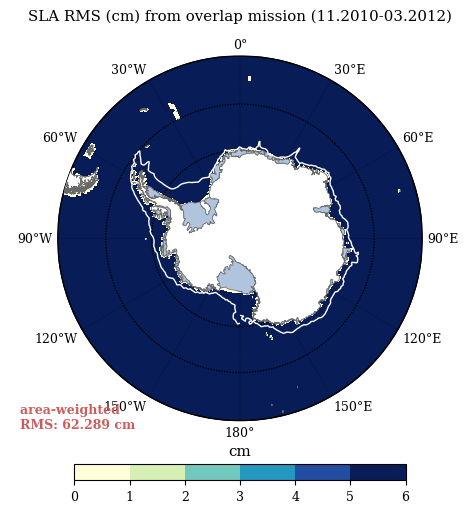

In [30]:
#c3b

"""
Compute RMS map and uncertainty estimate due to the intersatellite offset.

Intersat offset computed as area-weighted average of mean or median
of SLA differences durign the overlap period between ENV-CS2:

[mean_30bin]   egm08   / goco05c
    > mean   = 3.37 cm / 3.40 cm
    > median = 3.87 cm / 3.89 cm

[median_30bin]
    > mean   = 3.41 cm / 3.44 cm
    > median = 3.86 cm / 3.88 cm

> apply the median-based offset because it reduces the rms of SLA residuals
after correcting CS2 with the intersat offset

Last modified: 8 Apr 2021
"""

import numpy as np
from numpy import ma

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import xarray as xr
import pandas as pd

import sys

#----------------------------------------------------------
# Intersatellite offset (median, metres)
#intersat_off = 0.038519 # for SLA (SSH-geoid)
#intersat_off = 0.041194 # for SSHA (SSH-MSS)
#intersat_off = 0.041465 #(4_)
#intersat_off = 0.037683 #(6_, median)

# Define directories
voldir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
griddir = voldir + 'altimetry_cpom/3_grid_dot/'
figdir = voldir + '../PhD_figures/Figures_v8/'

scriptdir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_scripts/'
auxscriptdir = scriptdir + 'aux_func/'


sys.path.append(auxscriptdir)
import aux_func as fc
import aux_stereoplot as st

#----------------------------------------------------------
# # # # # # # # # # # #
geoidtype = '_goco05c' #'_goco05c' #'_egm08' #'_goco05c' #'_eigen6s4v2'
statistics = 'median'
intersat_off = 0.0384
# # # # # # # # # # # #

cs2_file = griddir + 'dot_cs2_30b' + statistics + geoidtype + '_sig3.nc'
env_file = griddir + 'dot_env_30b' + statistics + geoidtype + '_sig3.nc'

with xr.open_dataset(cs2_file) as cs2_dict:
    print(cs2_dict.keys())
with xr.open_dataset(env_file) as env_dict:
    print(env_dict.keys())

# overlap period
time = pd.date_range('2010-11-01', '2012-03-01', freq='1MS')

env = env_dict.sel(time=slice(time[0], time[-1]))
cs2 = cs2_dict.sel(time=slice(time[0], time[-1]))

print(env.keys())
print(cs2.keys())

# LAT/LON GRID
lat = env.latitude.values
lon = env.longitude.values
elat = env.edge_lat.values
elon = env.edge_lon.values

eglat, eglon = np.meshgrid(elat, elon)

lmask = env.land_mask.values

# DOT
cs2_dot = cs2.dot + intersat_off
env_dot = env.dot


# computing SLA relative to the overlap period mean SSH
#----------------------------------------------------------
cs2_mdt = cs2_dot.mean('time')
env_mdt = env_dot.mean('time')

cs2_sla = cs2_dot - env_mdt
env_sla = env_dot - env_mdt

# residuals
residuals = env_sla - cs2_sla
res_square = (residuals**2).sum('time')
n = len(residuals.time)
rms_map = np.sqrt(res_square/(n-1))


#----------------------------------------------------------
# area-weighted circumpolar SLA average - time series
area_grid = fc.grid_area(eglon, eglat)
area_grid[lmask==1] = np.nan # mask where land

# RMS at one point
aa = ma.masked_invalid(rms_map*area_grid)
total_area = ma.sum(area_grid[~aa.mask])
rms_pt = ma.sum(aa)/total_area

#----------------------------------------------------------
# don't display figures when running the script
#matplotlib.use('Agg')

savefigname = 'overlap_rms_intersat_bin.png'

cbar_range = [0, 6]
cbar_units = 'cm'
cmap = cm.get_cmap('YlGnBu', '6')

# # # # # # # # # # # #
plt.ion()
fig, ax, m = st.spstere_plot(eglon, eglat, rms_map*1e2,
                cbar_range, cmap, cbar_units, both)
fig.tight_layout(rect=[0, -.1, 1, .95])

fig.suptitle('SLA RMS (cm) from overlap mission (11.2010-03.2012)')

ax.annotate('area-weighted \nRMS: %.3f cm' %(rms_pt*1e2),
            xy=(0.04, 0.17),
            xycoords='figure fraction',
            color='indianred', weight='bold')



In [1]:
#c4
"""
Combine env and cs2 binned files to cover the full period;
- intersat offset is computed from binned data from the overlap of CS2 and ENV
- intersatellite offset is added to binned data to reference to Envisat.
- compute geostrophic velocity
- save all in a file using xarray

# Intersatellite offset (median, metres, without negative values)
# v6
#intersat_off = 0.03873
# v7, sigma=2
#intersat_off = 0.037405

# v7, sigma=3
#intersat_off = 0.038668 # bmedian, mean
#intersat_off = 0.03372 # bmean, mean

Last modified: 8 Apr 2021

~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
[mean_30bin]   egm08   / goco05c
    > mean   = 3.37 cm / 3.40 cm
    > median = 3.87 cm / 3.89 cm

[median_30bin]
    > mean   = 3.41 cm / 3.44 cm
    > median = 3.86 cm / 3.88 cm

> apply the median-based offset because it reduces the rms of SLA residuals
after correcting CS2 with the intersat offset

Last edited to merge two-weekly averages of DOT maps: 17 Oct 2022
"""

import numpy as np
from numpy import ma

from datetime import datetime
today = datetime.today()

import xarray as xr
import pandas as pd
import gsw

import sys

# Define directories
voldir = '/Users/iw2g24/PycharmProjects/CS2_extension/PhD/PhD_data/'
griddir = voldir + 'altimetry_cpom/3_grid_dot/'

#----------------------------------------------------------
# # # # # # # # # # # #
statistics = 'median'
geoidtype = '_goco05c'#'_eigen6s4v2' #'_egm08'  # '_goco05c'
# Gaussian filter - sigma and corresponding radius
gauss_sig = 3
# # # # # # # # # # # #

if statistics == 'median':
    if gauss_sig == 2:
        gauss_radius = '100km'
        if geoidtype == '_goco05c':
            intersat_off = 0.0386
        elif geoidtype == '_eigen6s4v2':
            intersat_off = 0.0393
    elif gauss_sig == 3:
        gauss_radius = '150km'
        if geoidtype == '_egm08':
            intersat_off = 0.0387
        elif geoidtype == '_goco05c':
            intersat_off = 0.0342 #0.0389 (3.89cm is for monthly averages; 3.42 cm is for 2-weekly avg)
        elif geoidtype == '_eigen6s4v2':
            intersat_off = 0.0384

print(gauss_radius, intersat_off)
# # # # # # # # # # # #

cs2_file = griddir + '2week_dot_cs2_30b' + statistics + geoidtype + '_sig' + str(gauss_sig) + '.nc'
env_file = griddir + '2week_dot_env_30b' + statistics + geoidtype + '_sig' + str(gauss_sig) + '.nc'

with xr.open_dataset(cs2_file) as cs2_dict:
    print(cs2_dict.keys())
with xr.open_dataset(env_file) as env_dict:
    print(env_dict.keys())

# LAT/LON GRID
lat = env_dict.latitude.values
lon = env_dict.longitude.values
elat = env_dict.edge_lat.values
elon = env_dict.edge_lon.values

# GRID
eglat, eglon = np.meshgrid(elat, elon)
glat, glon = np.meshgrid(lat, lon)
gmlat, gmlon = np.meshgrid(elat[1:-1], elon[1:-1])

lmask = env_dict.land_mask.values


# CS2 correction
cs2_dot = cs2_dict.dot + intersat_off

#----------------------------------------------------------
#time = pd.date_range('2002-07-01', '2018-10-01', freq='1MS')
#time_env = pd.date_range('2002-07-01', '2010-10-01', freq='1MS')
#time_overlap = pd.date_range('2010-11-01', '2012-03-01', freq='1MS')
#time_cs2 = pd.date_range('2012-04-01', '2018-10-01', freq='1MS')

time_env = env_dict.time.values
time_cs2 = cs2_dict.time.values

# time coord for the combined satellites
time = np.unique(np.concatenate((time_env, time_cs2)))
# find the intersection of the two time arrays; returns the sorted unique values
time_overlap = np.intersect1d(time_env, time_cs2)

# crop
dot_env = env_dict.dot.sel(time=slice(time_env[0], time_overlap[0])).values
dot_env_overlap = env_dict.dot.sel(time=slice(time_overlap[0], time_overlap[-1])).values
dot_cs2_overlap = cs2_dot.sel(time=slice(time_overlap[0], time_overlap[-1])).values
dot_cs2 = cs2_dot.sel(time=slice(time_overlap[-1], time_cs2[-1])).values
#----------------------------------------------------------
# combine satellites
dot_overlap = 0.5*(dot_env_overlap + dot_cs2_overlap)
# drop the last and first time slices because they are part of the overlap
dot = np.dstack((dot_env[:,:,:-1], dot_overlap, dot_cs2[:,:,1:]))

# apply land mask
dot[lmask==1] = np.nan

#----------------------------------------------------------
# dimensions
#londim, latdim, timdim = dot.shape

# forward and backward vel; use forward and backward vel for endpoints
# and avg mean for the in-between

# given the circumpolar/circular nature of the data,
# extend longitude by one grid step and append the first col to the end
lon_ext = np.hstack((lon, lon[-1] + 1))
dot_ext = np.concatenate((dot, dot[0:1,:,:]), axis=0)

#since map is circumpolar append first col to the end
glat_ext, glon_ext = np.meshgrid(lat, lon_ext)

# scale by f and g
f = gsw.f(glat)
g =  gsw.grav(glat, 0)

print("Computing gvel .. ")
# distance between grid points
# given the grid is uniform, no need to flip the arrays
dx = gsw.distance(glon_ext, glat_ext, axis=0)  # lon
dy = gsw.distance(glon, glat, axis=1)  # lat

# ---------- u vel ------------------
# a. forward diff
dnx_forw = dot_ext[1:] - dot_ext[:-1]
grad_x_forw = dnx_forw / dx[:, :, np.newaxis]

grad_x_avg = 0.5 * (grad_x_forw[1:] + grad_x_forw[:-1])
grad_x = np.concatenate((grad_x_forw[0:1, : , :], grad_x_avg), axis=0)

vg = grad_x * (g/f)[:, :, np.newaxis]

# ---------- v vel ------------------
# a. forward diff
dny_forw = dot[:, 1:, :] - dot[:, :-1, :]
grad_y_forw = dny_forw / dy[:, :, np.newaxis]

grad_y_avg = 0.5 * (grad_y_forw[:,1:,:] + grad_y_forw[:,:-1,:])
grad_y = np.concatenate((grad_y_forw[:, 0:1, :],
                        grad_y_avg,
                        grad_y_forw[:, -1, :][:,np.newaxis,:]), axis=1)

ug = (-1) * grad_y * (g/f)[:, :, np.newaxis]


#speed = np.sqrt(ug**2 + vg**2)
#mean_speed = speed.mean(axis=2)

#mean_u = np.mean(ug, axis=2)


# dsla_x = dot[1:] - dot[:-1]
# dsla_y = dot[:, 1:, :] - dot[:, :-1, :]

# # take differences along one axis ..
# dsla_dx = dsla_x/dx[:, :, np.newaxis]
# dsla_dy = dsla_y/dy[:, :, np.newaxis]

# # average along the other direction
# dsla_dx_mid = 0.5*(dsla_dx[:, 1:, :]+dsla_dx[:, :-1, :])
# dsla_dy_mid = 0.5*(dsla_dy[1:, :, :]+dsla_dy[:-1, :, :])

# # scale by f and g
# f = gsw.f(glat)
# g =  gsw.grav(glat, 0)

# vg = dsla_dx_mid * (g/f)[:, :, np.newaxis]
# ug = (-1) * dsla_dy_mid * (g/f)[:, :, np.newaxis]

# vellon = elon[1:-1]
# vellat = elat[1:-1]
#----------------------------------------------------------
# .nc file
newfile = '2week_dot_all_30b' + statistics + geoidtype +'_sig' + str(gauss_sig) + '.nc'

ds = xr.Dataset({'dot' : (('longitude', 'latitude', 'time'), dot),
                 'ug' : (('longitude', 'latitude', 'time'), ug),
                 'vg' : (('longitude', 'latitude', 'time'), vg),
                 'land_mask' : (('longitude', 'latitude'), lmask),
                 'intersat_offset' : intersat_off},
                coords={'longitude' : lon,
                        'latitude' : lat,
                        'time' : time,
                        'edge_lat' : elat,
                        'edge_lon' : elon})

ds.attrs['history'] = "Created " + today.strftime("%d/%m/%Y, %H:%M%S" )
ds.dot.attrs['units']='meters'
ds.ug.attrs['units']='metres/second'
ds.vg.attrs['units']='metres/second'
ds.ug.attrs['long_name']='zonal_surface_geostrophic_velocity'
ds.vg.attrs['long_name']='meridional_surface_geostrophic_velocity'
ds.dot.attrs['long_name']='dynamic_ocean_topography'
ds.intersat_offset.attrs['units']='metres'

description_text = (("ENVISAT + CryoSat2 altimetry (geoid:%s) \n"
"env: 07.2002-03.2012 || cs2:11.2010-10.2018 \n"
"> Lat, Lon at bin centre and edges(for pcolormesh) \n"
"> DOT (bin_statistic: %s, |DOT| < 3m) \n"
"> time (bi-weekly from the start of each month; the mean is over 1-15/15-end days of every month) \n"
"> compute value only where bins have more than 30 points \n"
"> land mask (land=1, ocean=0) \n"
"> *intersat offset = area-weighted average of "
"median of binned SLA_env-SLA_cs2 in the overlap period referenced to MDT_env \n"
" Intersatellite offset of %s m has been applied to binned CS2."
" Gaussian filter (sig=%s, %s) applied to binned data ") %
(geoidtype, statistics, intersat_off, gauss_sig, gauss_radius))

ds.attrs['description'] = description_text
ds.to_netcdf(griddir+newfile)

sys.exit()

# b. backwards diff
#xflip_dot = np.flip(dot_ext, axis=0)
#dnx_back = np.flip(xflip_dot[1:] - xflip_dot[:-1], axis=0)
#grad_x_back = dnx_back / dx[:, :, np.newaxis]

# c. average of forward + backwards
#grad_x_avg = 0.5 * (grad_x_forw[:-1] + grad_x_back[1:])

# use first forward vel as the first entry
#grad_x = np.concatenate((grad_x_forw[0:1, : , :], grad_x_avg), axis=0)


# # b. backwards diff
# yflip_dot = np.flip(dot, axis=1)
# dny_back = np.flip(yflip_dot[:, 1:, :] - yflip_dot[:, :-1, :], axis=1)
# grad_y_back = dny_back / dy[:, :, np.newaxis]

# # c. average of forward + backwards
# grad_y_avg = 0.5 * (grad_y_forw[:, :-1, :] + grad_y_back[:, 1:, :])

# # use first forward vel as the first entry
# grad_y = np.concatenate((grad_y_forw[:, 0:1 , :], grad_y_avg, grad_y_back[:,-1:-2, :]), axis=1)

"""

ds = Dataset(datadir + newfile, 'w')

# dimensions
lo, la, itt = dot.shape

ds.createDimension('lon', lo)
ds.createDimension('elon', lo+1)
ds.createDimension('lat', la)
ds.createDimension('elat', la+1)
ds.createDimension('idx', itt)
ds.createDimension('n1', 1)

# variables
lati = ds.createVariable('latitude', np.float64, ('lat'))
longi = ds.createVariable('longitude', np.float64, ('lon'))
elati = ds.createVariable('edges_lat', np.float64, ('elat',))
elongi = ds.createVariable('edges_lon', np.float64, ('elon',))
SSH = ds.createVariable('dot', np.float64, ('lon', 'lat', 'idx'))
SLA = ds.createVariable('sla', np.float64, ('lon', 'lat', 'idx'))
MDT = ds.createVariable('mdt', np.float64, ('lon', 'lat'))
numpts = ds.createVariable('num_pts', np.float64, ('lon', 'lat', 'idx'))
tim = ds.createVariable('time', np.float64, ('idx'))
land_mask = ds.createVariable('landmask', np.int32, ('lon', 'lat'))
intersat_mask = ds.createVariable('intersat_mask', np.int32, ('lon', 'lat'))
intersat = ds.createVariable('intersatellite_offset', np.float32, ('n1',))

ds.description = ("ENV + CryoSat2: \
*Lat, Lon at bin centre and edges \
*DOT (corrected, median of bin)\
*SLA (ref to mean over all period)\
*MDT\
*time (beginning of month)\
env:07.2002-03.2012; cs2:11.2010-10.2018\
*number of points in bins\
*land mask (land=1, ocean=0).\
*intersatellite mask (0 where offset < 0, 1 otherwise)\
Data have been filtered by sea-ice type\
and have the land mask applied.\
Intersatellite offset has been applied\
to along-track CS2 (3.7405 cm).")

ds.history = "Created " + today.strftime("%d/%m/%Y, %H:%M%S" )

tim.units = time_units
SSH.units='meters'
lati.units='degrees_north'
longi.units='degrees_east'
elati.units='degrees_north'
elongi.units='degrees_east'
SSH.long_name='dynamic_ocean_topography'
SLA.long_name='sea_level_anomaly'
MDT.long_name='mean_dynamic_ocean_topography'

lati[:] = lat
longi[:] = lon
elongi[:] = elon
elati[:] = elat
SSH[:] = dot.filled(np.nan)
SLA[:] = sla.filled(np.nan)
MDT[:] = mdt.filled(np.nan)
numpts[:] = num_pts
tim[:] = time
land_mask[:] = lmask.filled(np.nan)
intersat_mask[:] = offsetmask.filled(np.nan)
intersat = intersat_off

ds.close()


u = ma.zeros((londim, latdim-1, timdim))
v = ma.zeros((londim-1, latdim, timdim))
for t in range(timdim):
    for x in range(londim):
        u[x, :, t] = gsw.geostrophic_velocity(dot[x, :, t], glon[x, :], glat[x, :],
                                           p=0)[0]
    for y in range(latdim):
        v[:, y, t] = gsw.geostrophic_velocity(dot[:, y, t], glon[:, y], glat[:, y],
                                           p=0)[0]

# zonal vel is +ve eastward and meridional vel is +ve northward
u = (-1)*u
v = v
# reduce the other dimension by 1
ug_vel = 0.5*(u[1:, :, :] + u[:-1, :, :])
vg_vel = 0.5*(v[:, 1:, :] + v[:, :-1, :])

# scale by g
ug_vel *= g[:, :, np.newaxis]
vg_vel *= g[:, :, np.newaxis]

t_stop = runtime.process_time()
print("execution time: %.3f s " %(t_stop-t_start))
"""


150km 0.0342
KeysView(<xarray.Dataset> Size: 19MB
Dimensions:    (longitude: 360, latitude: 64, time: 34, edge_lat: 65,
                edge_lon: 361)
Coordinates:
  * longitude  (longitude) float64 3kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float64 512B -81.75 -81.25 -80.75 ... -50.75 -50.25
  * time       (time) datetime64[ns] 272B 2010-11-01 2010-11-15 ... 2012-03-15
  * edge_lat   (edge_lat) float64 520B -82.0 -81.5 -81.0 ... -51.0 -50.5 -50.0
  * edge_lon   (edge_lon) float64 3kB -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
Data variables:
    dot        (longitude, latitude, time) float64 6MB ...
    sla        (longitude, latitude, time) float64 6MB ...
    mdt        (longitude, latitude) float64 184kB ...
    num_pts    (longitude, latitude, time) float64 6MB ...
    land_mask  (longitude, latitude) float64 184kB ...
Attributes:
    history:      Created 30/05/2025, 16:5807
    description:  CS2: |*Lat, Lon at bin centre and edges |*DOT (bin median, ...)


SystemExit: 

/Users/iw2g24/PycharmProjects/SSH_project/.venv1/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
